In [2]:
import sys 
sys.path.append("..")

In [3]:
import umap
import operator
import shap
from xgboost import XGBClassifier
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from ksvd import ApproximateKSVD
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
#from comon import creatMas, plot_ssp, creat_data_month
from comon import *
from plots_report import plot_metrics

Using TensorFlow backend.


In [4]:
ocean = 'BarentsSea'

In [5]:
files = ['CZ1.txt', 'CZ2.txt', 'CZ3.txt', 'CZ4.txt','CZ5.txt', 'CZ6.txt',
         'CZ7.txt','CZ8.txt','CZ9.txt','CZ10.txt', 'CZ11.txt','CZ12.txt']

CZ = []
for file in files:
    with open('{0}/{1}'.format(ocean, file), 'r') as f:
        line = f.readlines()
        cz=creatMas(line)
    CZ.append(cz)
    
_, N_cord = cz.shape

with open('{}/zs.txt'.format(ocean), 'r') as f:
    line = f.readlines()
    line.remove(line[N_cord])
zs = [-int(a) for a in line]

In [6]:
X, Y = creat_data_month(CZ, N=200)
X = pd.DataFrame(X, columns=zs)
X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=0.2, stratify=Y, random_state=0)

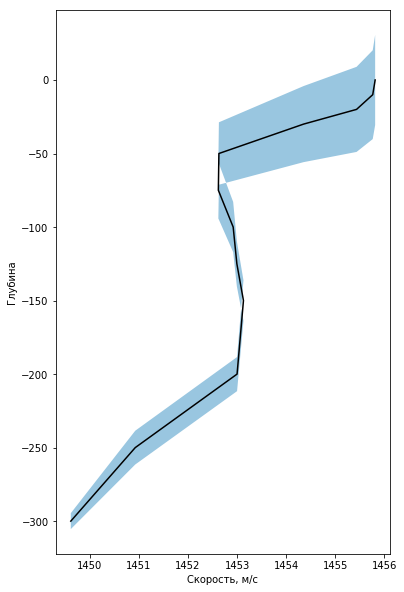

In [43]:
x  = np.array(X)
x_std = np.std(x, axis=0)
x_mean = np.mean(x, axis=0)
plt.figure(figsize=(6,10))
plt.plot(x_mean,zs, 'k')
plt.ylabel('Глубина')
plt.xlabel('Скорость, м/с')
plt.fill_between(x_mean, zs - 3*x_std, zs + 3*x_std, alpha=0.4)
plt.show()

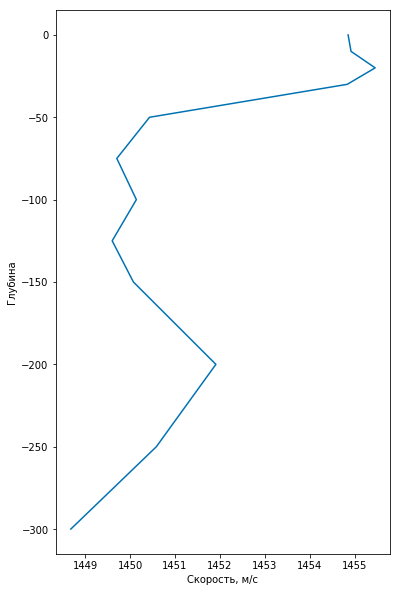

In [60]:
plt.figure(figsize=(6,10))
plt.plot(X_train.values[8], zs)
plt.ylabel('Глубина')
plt.xlabel('Скорость, м/с')
plt.show()

## Кластеризация

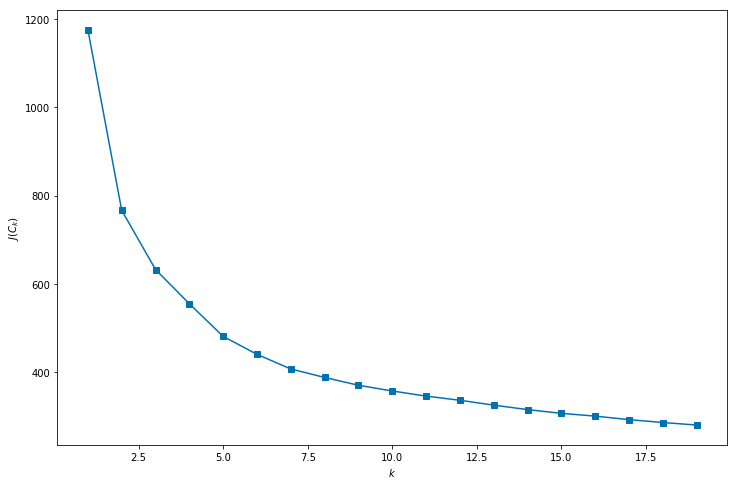

In [8]:
plt.figure(figsize=(12,8))
inertia = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 20), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

## Классификация

In [20]:
clf = LogisticRegression(C=10)
clf.fit(X_train,y_train)
predict = clf.predict(X_test)
acc_lg = accuracy_score(y_test,predict)
print('accuracy_score: ', acc_lg)
print(confusion_matrix(y_test,predict))
print(classification_report(y_test,predict))

accuracy_score:  0.8520833333333333
[[32  2  3  2  1  0  0  0  0  0  0  0]
 [ 0 33  1  0  6  0  0  0  0  0  0  0]
 [ 3  1 31  5  0  0  0  0  0  0  0  0]
 [10  0  8 16  5  0  0  0  0  0  0  1]
 [ 1  2  0  0 30  6  0  0  0  0  1  0]
 [ 0  0  1  0  0 38  0  0  0  0  0  1]
 [ 0  0  0  0  0  1 39  0  0  0  0  0]
 [ 0  0  0  0  0  0  2 35  3  0  0  0]
 [ 0  0  0  0  0  0  0  0 40  0  0  0]
 [ 0  0  0  0  0  0  0  0  1 39  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 40  0]
 [ 1  0  2  0  0  0  0  0  0  0  1 36]]
              precision    recall  f1-score   support

           0       0.68      0.80      0.74        40
           1       0.87      0.82      0.85        40
           2       0.67      0.78      0.72        40
           3       0.70      0.40      0.51        40
           4       0.71      0.75      0.73        40
           5       0.84      0.95      0.89        40
           6       0.95      0.97      0.96        40
           7       1.00      0.88      0.93        40
        

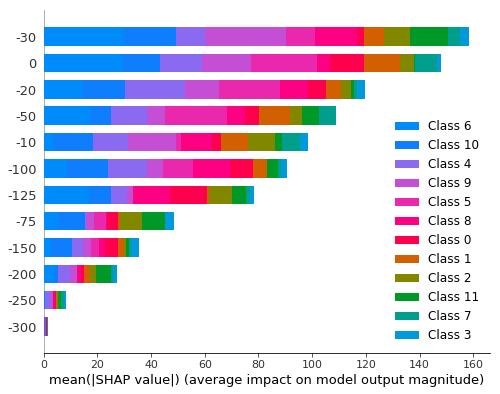

In [9]:
explainer = shap.LinearExplainer(clf, X_test)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type = "bar")

In [21]:
score_pca = researcher_pca(LogisticRegression, X_train, y_train, X_test, y_test, C=20, n_comp=[2,3,5,7,10,12])
score_pca

[0.2625,
 0.40625,
 0.56875,
 0.7583333333333333,
 0.9041666666666667,
 0.9145833333333333]

In [22]:
score_kmeans = researcher_kmeans(LogisticRegression, X_train.values, y_train, X_test.values, y_test,C=20, n_comp=[2,3,5,7,10,11])
score_kmeans

[0.16041666666666668,
 0.15625,
 0.19791666666666666,
 0.20416666666666666,
 0.2375,
 0.25]

In [23]:
score_ksvd = researcher_ksvd(LogisticRegression, X_train.values, y_train, X_test.values, y_test, C=20, n_comp=[2,3,5,7,10,11])
score_ksvd

[0.23125,
 0.19583333333333333,
 0.48333333333333334,
 0.7104166666666667,
 0.8916666666666667,
 0.90625]

In [24]:
score_ae = researcher_ae(LogisticRegression, X_train.values, y_train, X_test.values, y_test, epochs=1200, n_units=[2,3,5,7,10,12], C=20)
score_ae

[0.5416666666666666,
 0.5270833333333333,
 0.5708333333333333,
 0.75625,
 0.7541666666666667,
 0.7375]

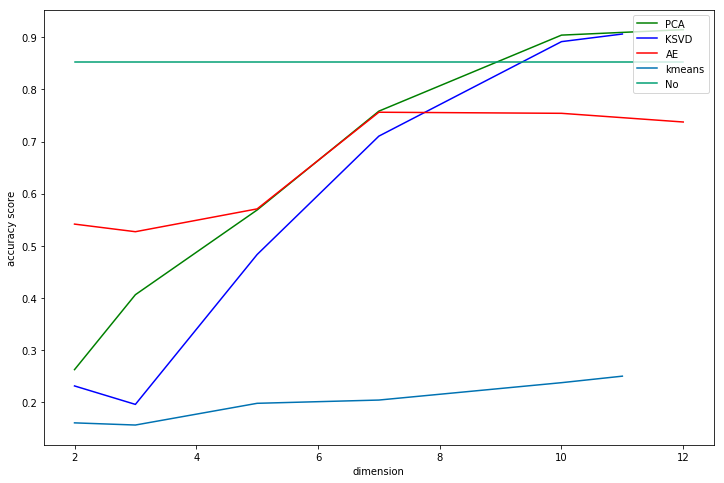

In [25]:
plt.figure(figsize=(12,8))
plt.plot([2,3,5,7,10,12], score_pca, 'g', [2,3,5,7,10,11], score_ksvd, 'b',
         [2,3,5,7,10,12], score_ae, 'r', [2,3,5,7,10,11], score_kmeans, [2,12], [acc_lg,acc_lg])
plt.legend(('PCA', 'KSVD', 'AE', 'kmeans', 'No'),
           loc='upper right')
plt.xlabel('dimension')
plt.ylabel('accuracy score')
plt.show()

## RF

In [10]:
clf = RandomForestClassifier(n_estimators=500)
clf.fit(X_train,y_train)
predict = clf.predict(X_test)
acc_rf = accuracy_score(y_test,predict)
print('accuracy_score: ', acc_rf)
print(confusion_matrix(y_test,predict))
print(classification_report(y_test,predict))

accuracy_score:  0.9145833333333333
[[33  2  0  1  0  0  0  0  0  0  0  4]
 [ 2 38  0  0  0  0  0  0  0  0  0  0]
 [ 1  1 35  2  0  1  0  0  0  0  0  0]
 [ 0  0  1 38  1  0  0  0  0  0  0  0]
 [ 0  0  0  2 33  1  0  0  0  0  2  2]
 [ 0  0  0  1  0 39  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 39  1  0  0  0  0]
 [ 0  0  0  0  0  0  0 38  2  0  0  0]
 [ 0  0  0  0  0  0  2  0 38  0  0  0]
 [ 1  0  0  1  0  0  0  0  0 38  0  0]
 [ 0  1  0  1  0  0  0  0  0  1 37  0]
 [ 1  1  0  0  0  0  0  0  0  0  5 33]]
              precision    recall  f1-score   support

           0       0.87      0.82      0.85        40
           1       0.88      0.95      0.92        40
           2       0.97      0.88      0.92        40
           3       0.83      0.95      0.88        40
           4       0.97      0.82      0.89        40
           5       0.95      0.97      0.96        40
           6       0.95      0.97      0.96        40
           7       0.97      0.95      0.96        40
        

In [26]:
score_pca = researcher_pca(RandomForestClassifier, X_train, y_train, X_test, y_test, n_estimators=500, n_comp=[2,3,5,7,10,12])
score_pca

[0.46458333333333335,
 0.7541666666666667,
 0.9041666666666667,
 0.95625,
 0.9833333333333333,
 0.99375]

In [27]:
score_kmeans = researcher_kmeans(RandomForestClassifier, X_train.values, y_train, X_test.values, y_test,n_estimators=500, n_comp=[2,3,5,7,10,11])
score_kmeans

[0.16041666666666668,
 0.14375,
 0.19791666666666666,
 0.20416666666666666,
 0.23541666666666666,
 0.24166666666666667]

In [28]:
score_ksvd = researcher_ksvd(RandomForestClassifier, X_train.values, y_train, X_test.values, y_test, n_estimators=500, n_comp=[2,3,5,7,10,11])
score_ksvd

[0.22916666666666666,
 0.27291666666666664,
 0.84375,
 0.9354166666666667,
 0.9854166666666667,
 0.9854166666666667]

In [29]:
score_ae = researcher_ae(RandomForestClassifier, X_train.values, y_train, X_test.values, y_test, epochs=1200, n_units=[2,3,5,7,10,12], n_estimators=500)
score_ae

[0.7291666666666666,
 0.8729166666666667,
 0.8979166666666667,
 0.9541666666666667,
 0.9520833333333333,
 0.9291666666666667]

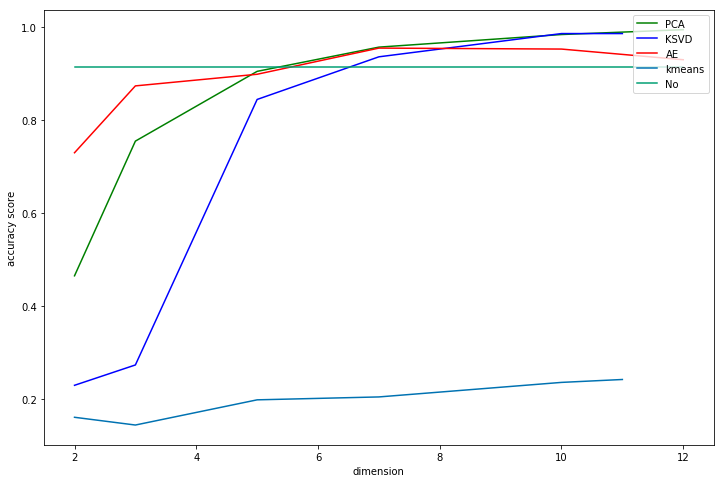

In [30]:
plt.figure(figsize=(12,8))
plt.plot([2,3,5,7,10,12], score_pca, 'g', [2,3,5,7,10,11], score_ksvd, 'b',
         [2,3,5,7,10,12], score_ae, 'r', [2,3,5,7,10,11], score_kmeans, [2,12], [acc_rf,acc_rf])
plt.legend(('PCA', 'KSVD', 'AE', 'kmeans', 'No'),
           loc='upper right')
plt.xlabel('dimension')
plt.ylabel('accuracy score')
plt.show()

## XGBoost

In [11]:
clf = XGBClassifier(n_estimators=500)
clf.fit(X_train,y_train)
predict = clf.predict(X_test)
xgb_acc = accuracy_score(y_test,predict)
print('accuracy_score: ', xgb_acc)
print(confusion_matrix(y_test,predict))
print(classification_report(y_test,predict))

accuracy_score:  0.9208333333333333
[[35  2  1  0  0  0  0  0  0  0  0  2]
 [ 1 38  1  0  0  0  0  0  0  0  0  0]
 [ 0  1 38  1  0  0  0  0  0  0  0  0]
 [ 0  0  0 38  2  0  0  0  0  0  0  0]
 [ 0  0  0  2 32  0  0  0  0  2  3  1]
 [ 0  0  0  0  0 40  0  0  0  0  0  0]
 [ 1  0  0  0  0  1 37  0  1  0  0  0]
 [ 0  0  0  0  0  0  0 38  2  0  0  0]
 [ 0  0  0  0  0  0  1  1 38  0  0  0]
 [ 1  0  0  0  1  0  0  0  0 38  0  0]
 [ 0  1  0  0  1  0  0  0  0  1 37  0]
 [ 1  0  0  0  0  0  0  0  0  0  6 33]]
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        40
           1       0.90      0.95      0.93        40
           2       0.95      0.95      0.95        40
           3       0.93      0.95      0.94        40
           4       0.89      0.80      0.84        40
           5       0.98      1.00      0.99        40
           6       0.97      0.93      0.95        40
           7       0.97      0.95      0.96        40
        

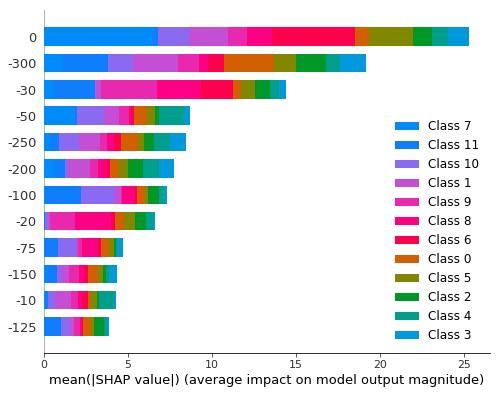

In [12]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type = "bar")

In [84]:
dec = PCA(n_components=len(zs))
clf = XGBClassifier(n_estimators=500)
pipe = Pipeline([('dec', dec), ('clf', clf)])
pipe.fit(X_train, y_train)
predict = pipe.predict(X_test)

print('accuracy_score: ', accuracy_score(y_test,predict))
print(confusion_matrix(y_test,predict))
print(classification_report(y_test,predict))

accuracy_score:  0.998214285714
[[140   0   0   0   0   0   0   0   0   0   0   0]
 [  1 139   0   0   0   0   0   0   0   0   0   0]
 [  0   0 140   0   0   0   0   0   0   0   0   0]
 [  1   0   0 139   0   0   0   0   0   0   0   0]
 [  0   0   0   0 140   0   0   0   0   0   0   0]
 [  0   0   0   0   0 140   0   0   0   0   0   0]
 [  0   0   0   0   0   0 140   0   0   0   0   0]
 [  0   0   0   0   0   0   0 140   0   0   0   0]
 [  0   0   0   0   0   0   0   0 140   0   0   0]
 [  0   0   0   0   0   0   0   0   0 140   0   0]
 [  0   0   0   0   0   0   0   0   0   0 139   1]
 [  0   0   0   0   0   0   0   0   0   0   0 140]]
             precision    recall  f1-score   support

          0       0.99      1.00      0.99       140
          1       1.00      0.99      1.00       140
          2       1.00      1.00      1.00       140
          3       1.00      0.99      1.00       140
          4       1.00      1.00      1.00       140
          5       1.00      1.00    

## Важность компонент

**pca**

In [31]:
pca = PCA(n_components=len(zs))
pca.fit(X_train)
x_coef = pca.transform(X_train)
x_coef = pd.DataFrame(x_coef, columns = ['component {0}'.format(i) for i in range(1,len(zs)+1)])

In [32]:
clf = XGBClassifier(n_estimators=500)
clf.fit(x_coef,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

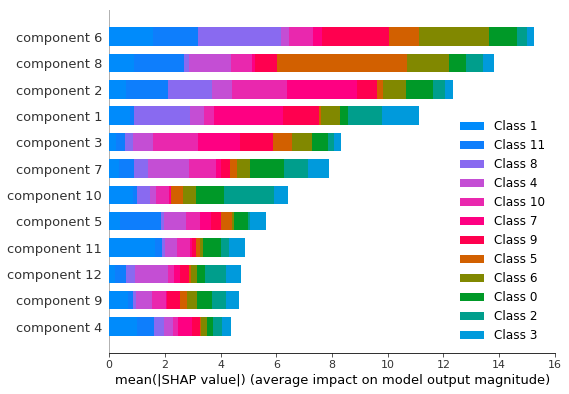

In [11]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(x_coef)
shap.summary_plot(shap_values, x_coef, plot_type = "bar")

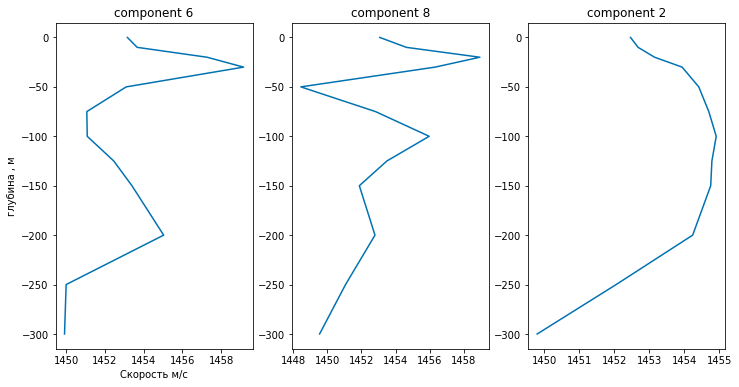

In [37]:
best_comp = [6,8,2]
n = len(best_comp)
comp = pca.components_
i=1
plt.figure(figsize=(12,6))
for bc in best_comp:
    plt.subplot(1,n, i)
    plt.plot(comp[bc-1,:]*x_std+x_mean,zs)
    plt.title('component {0}'.format(bc))
    if i == 1:
        plt.xlabel('Скорость м/с')
        plt.ylabel('глубина , м')
    i+=1
plt.show()

**ksvd**

In [39]:
ksvd = ApproximateKSVD(n_components=11, transform_n_nonzero_coefs=9)
meantr = np.mean(np.array(X_train),axis=0)
ksvd.fit(np.array(X_train) - meantr).components_
gamma_train = ksvd.transform(np.array(X_train) - meantr)
gamma_test = ksvd.transform(np.array(X_test) - meantr)

In [40]:
x_coef = pd.DataFrame(gamma_train, columns = ['component {0}'.format(i) for i in range(1,len(zs))])

In [41]:
clf = XGBClassifier(n_estimators=500)
clf.fit(x_coef,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

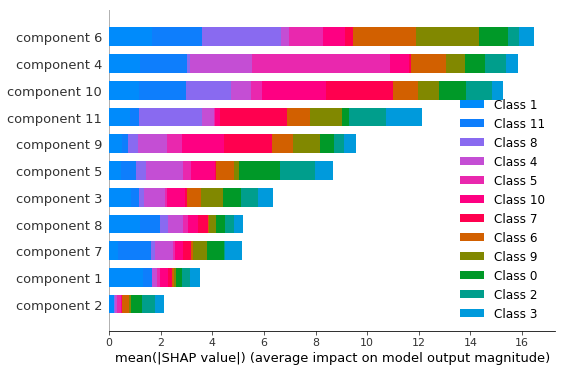

In [48]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(x_coef)
shap.summary_plot(shap_values, x_coef, plot_type = "bar")

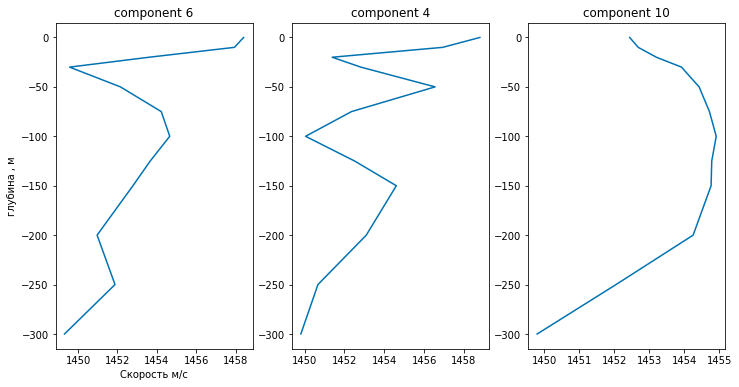

In [42]:
best_comp = [6,4,10]
n = len(best_comp)
comp = ksvd.components_
i=1
plt.figure(figsize=(12,6))
for bc in best_comp:
    plt.subplot(1,n, i)
    plt.plot(comp[bc-1,:]*x_std+x_mean,zs)
    plt.title('component {0}'.format(bc))
    if i == 1:
        plt.xlabel('Скорость м/с')
        plt.ylabel('глубина , м')
    i+=1
plt.show()

## Качество классификации при снижении размерности

In [26]:
score_pca = researcher_pca(XGBClassifier, X_train, y_train, X_test, y_test, n_estimators=500, n_comp=[2,3,5,7,10,12])
score_pca

[0.46041666666666664,
 0.7291666666666666,
 0.8604166666666667,
 0.9604166666666667,
 0.975,
 0.9729166666666667]

In [27]:
score_kmeans = researcher_kmeans(LogisticRegression, X_train.values, y_train, X_test.values, y_test,C=10, n_comp=[2,3,5,7,10,11])
score_kmeans

[0.16041666666666668,
 0.15625,
 0.19791666666666666,
 0.20416666666666666,
 0.25833333333333336,
 0.2604166666666667]

In [28]:
score_ksvd = researcher_ksvd(XGBClassifier, X_train.values, y_train, X_test.values, y_test, n_estimators=500, n_comp=[2,3,5,7,10,11])
score_ksvd

[0.2708333333333333,
 0.32083333333333336,
 0.7479166666666667,
 0.9041666666666667,
 0.9708333333333333,
 0.9729166666666667]

In [29]:
score_ae = researcher_ae(XGBClassifier, X_train.values, y_train, X_test.values, y_test, epochs=1200, n_units=[2,3,5,7,10,12], n_estimators=500)
score_ae

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


[0.4270833333333333,
 0.6458333333333334,
 0.875,
 0.9291666666666667,
 0.9104166666666667,
 0.9520833333333333]

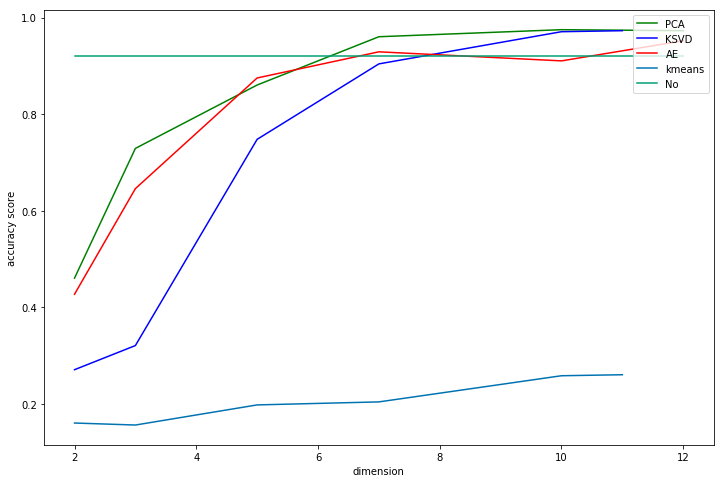

In [32]:
plt.figure(figsize=(12,8))
plt.plot([2,3,5,7,10,12], score_pca, 'g', [2,3,5,7,10,11], score_ksvd, 'b',
         [2,3,5,7,10,12], score_ae, 'r', [2,3,5,7,10,11], score_kmeans, [2,12], [xgb_acc,xgb_acc])
plt.legend(('PCA', 'KSVD', 'AE', 'kmeans', 'No'),
           loc='upper right')
plt.xlabel('dimension')
plt.ylabel('accuracy score')
plt.show()

**подробнее про k-svd**

In [51]:
Score_ksvd = []
for k in range(0, 11, 2):
    score_ksvd = researcher_ksvd(XGBClassifier, X_train.values, y_train, X_test.values, y_test, k=k, n_estimators=500, n_comp=[2,3,5,7,10,11])
    Score_ksvd.append(score_ksvd)

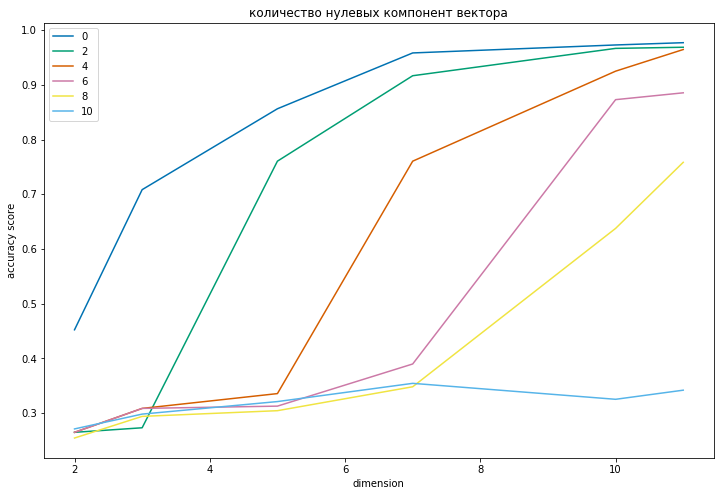

In [55]:
plt.figure(figsize=(12,8))
for score in Score_ksvd:
    plt.plot([2,3,5,7,10,11], score)
plt.legend(tuple([str(i) for i in range(0,11, 2)]),
           loc='upper left')
plt.title('количество нулевых компонент вектора')
plt.xlabel('dimension')
plt.ylabel('accuracy score')
plt.show()

## Визуализация по месяцам

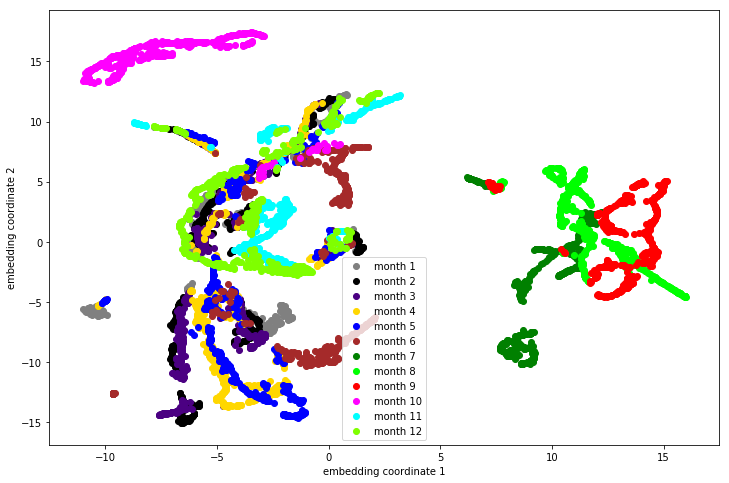

In [40]:
embedding = umap.UMAP()
AllX = []
for x in CZ:
    AllX += list(x)
embedding.fit(AllX)

plt.figure(figsize=(12,8))
color = ['grey', 'black', 'indigo', 'gold', 'blue', 'brown', 'green', 'lime', 'red', 'fuchsia', 'cyan', 'chartreuse']
for i in range(12):
    x_emb = embedding.transform(CZ[i])
    plt.scatter(x_emb[:,0], x_emb[:,1], label='month {}'.format(i+1), c=color[i])
plt.legend()
plt.xlabel('embedding coordinate 1')
plt.ylabel('embedding coordinate 2')
plt.show()

**визуальная разделимость от колличества  компонент PCA**

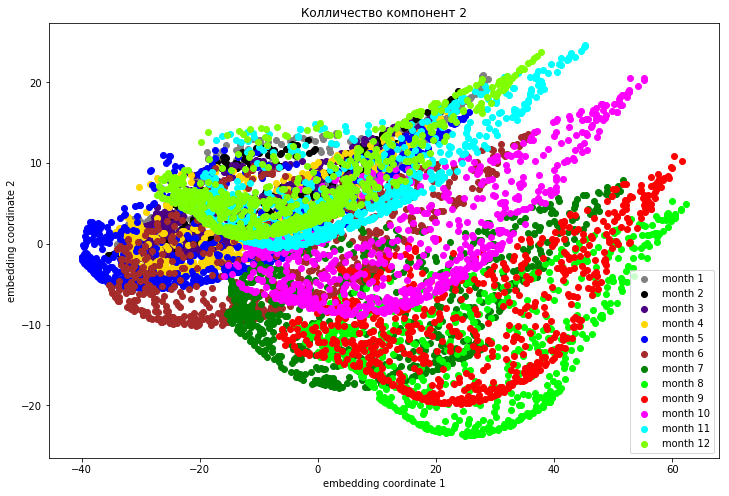

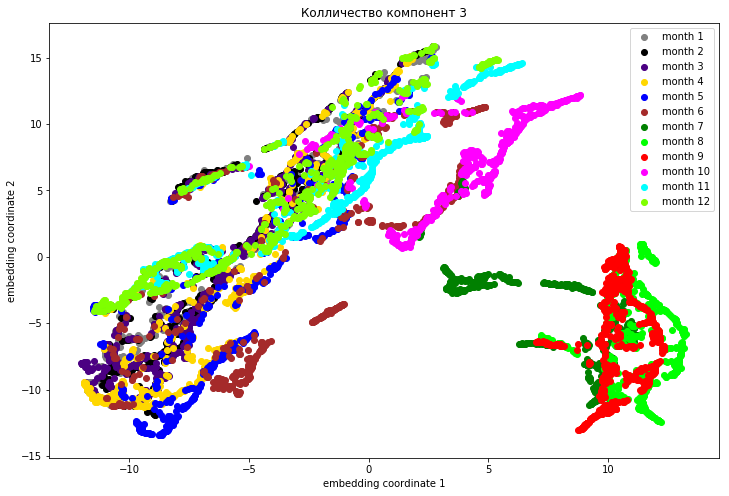

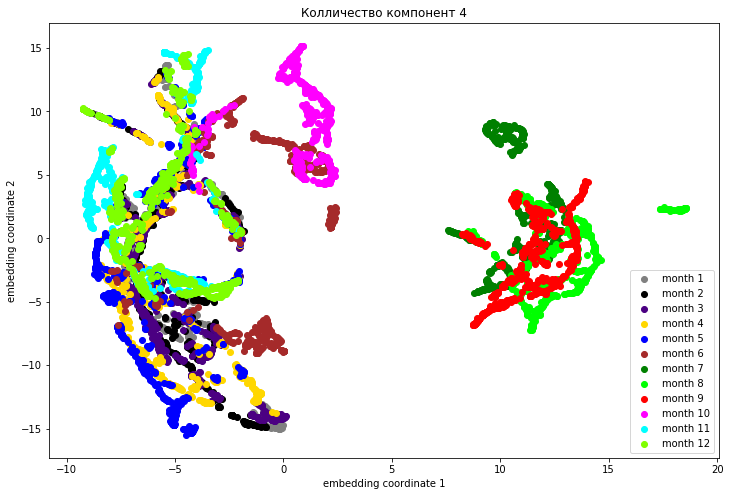

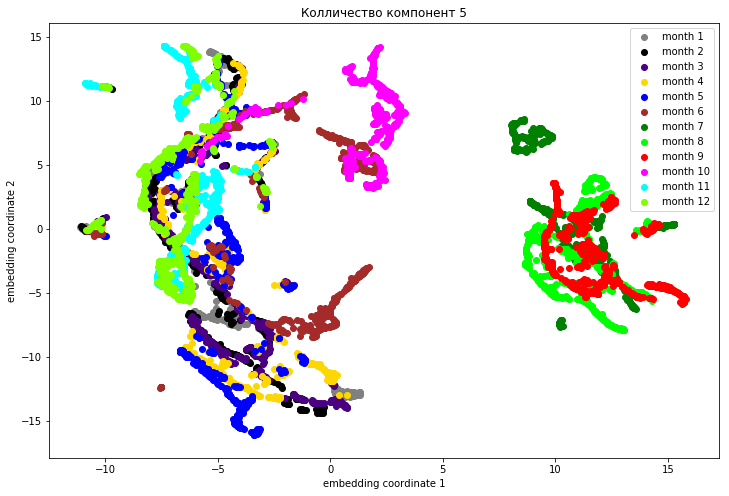

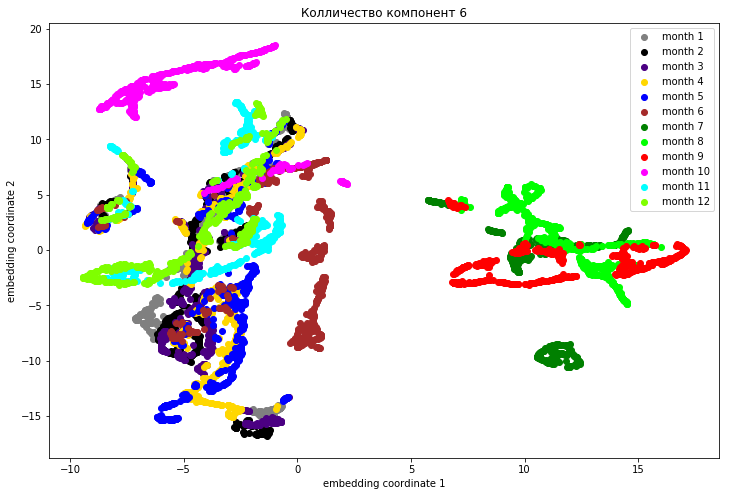

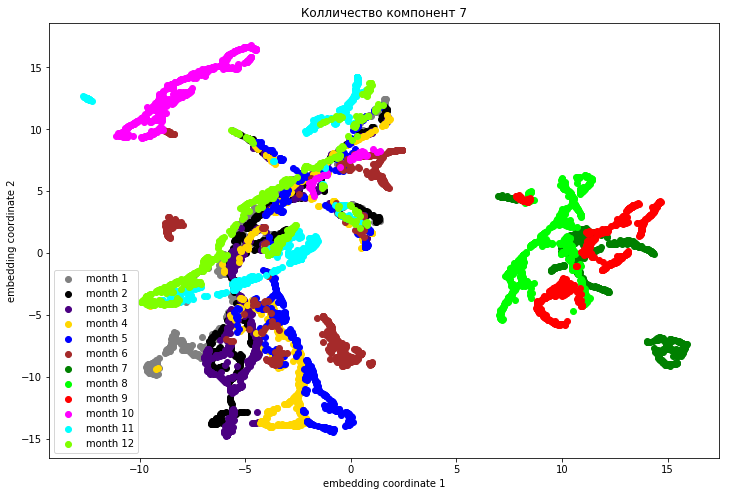

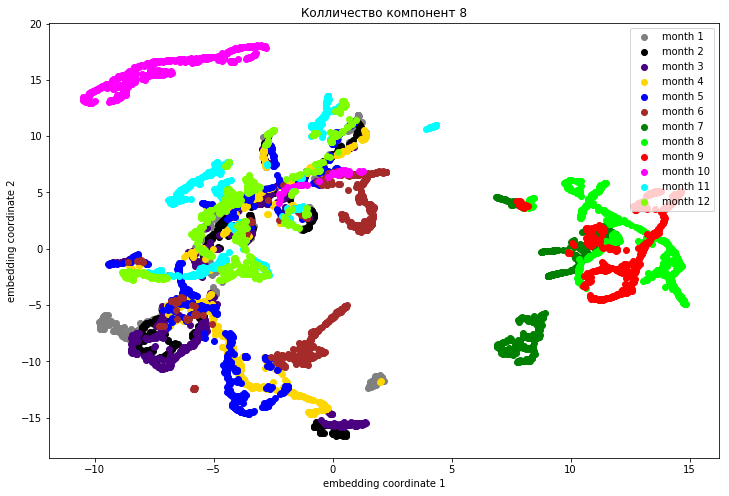

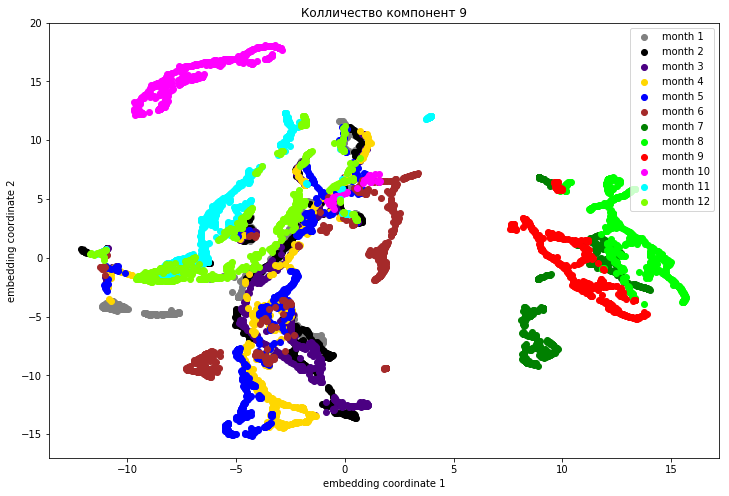

In [41]:
for n_comp in range(2,10):
    pca = PCA(n_components=n_comp)
    AllX_red = pca.fit_transform(AllX)
    embedding.fit(AllX_red)
    plt.figure(figsize=(12,8))
    for i in range(12):
        if n_comp == 2: x_emb = pca.transform(CZ[i])
        else: x_emb = embedding.transform(pca.transform(CZ[i]))
        plt.scatter(x_emb[:,0], x_emb[:,1], label='month {}'.format(i+1), c=color[i])
        plt.title("Колличество компонент {}".format(n_comp))
        plt.legend()
    plt.xlabel('embedding coordinate 1')
    plt.ylabel('embedding coordinate 2')
    plt.show()